In [1]:
import keras
import os
import tempfile
import keras.backend as K
import math
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import tensorflow as tf
import time
import pandas as pd
import seaborn as sns
import csv 
from sklearn.preprocessing import StandardScaler

from keras import optimizers, metrics
from keras import activations
from keras.layers import Dense, LayerNormalization, BatchNormalization, Dropout, GaussianNoise, Activation, Add

from tools.constants import column_labels_particle_assignment as column_names

In [2]:
""" Data augmentation functions. Rotate all particles of an event (or a permutation of an event)
    by a random angle. """

def random_rotation(X,deltas_phi,num_vectors,met):

    for i in range(num_vectors):
        
        R = np.sqrt((X[:,4*i+0]**2 + X[:,4*i+1]**2))
        old_phis = np.arctan2(X[:,4*i+1],X[:,4*i+0])
        new_phis = old_phis + deltas_phi

        angles_sin = np.sin(new_phis)
        angles_cos = np.cos(new_phis)

        X[:,4*i+0] = angles_cos * R
        X[:,4*i+1] = angles_sin * R
        
    if met:
        return random_rotation_MET(X, deltas_phi)
    else:
        return X


def random_rotation_MET(X, deltas_phi):
    met_x_index = -6
    met_y_index = -5

    R = np.sqrt((X[:,met_x_index]**2 + X[:,met_y_index]**2))
    old_phis = np.arctan2(X[:,met_y_index],(X[:,met_x_index]))
    new_phis = old_phis + deltas_phi

    angles_sin = np.sin(new_phis)
    angles_cos = np.cos(new_phis)

    X[:,met_x_index] = angles_cos * R
    X[:,met_y_index] = angles_sin * R

    return X


def data_rotation(X, num_vectors_X = 11, met = True):  
    
    deltas_phi = np.random.rand(X.shape[0])*2*math.pi
    X = random_rotation(X,deltas_phi,num_vectors_X,met)
        
    return X

""" Data generator class. Used to serve data to the neural network.
    Modified from source https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly """

column_labels = ["event id","top b px","top b py","top b pz","top b E",\
"antitop b px","antitop b py","antitop b pz","antitop b E",\
"top W px","top W py","top W pz","top W E",\
"main lepton px","main lepton py","main lepton pz","main lepton E",\
"antitop lepton px","antitop lepton py","antitop lepton pz","antitop lepton E",\
"top W q1 px","top W q1 py","top W q1 pz","top W q1 E",\
"top W q2 px","top W q2 py","top W q2 pz","top W q2 E",\
"hadr tau px","hadr tau py","hadr tau pz","hadr tau E",\
"top px","top py","top pz","top E",\
"visible antitop px","visible antitop py","visible antitop pz","visible antitop E",\
"visible main px","visible main py","visible main pz","visible main E",\
"top b mass","anti top b mass","top W mass","main lepton mass",\
"antitop lepton mass","top W q1 mass","top W q2 mass","top mass",\
"visible antitop top mass","visible main mass",\
"q1 and q2 delta R","hadr tau and main lep delta R","hadr tau and antitop lep delta R","anti top b and main lep delta R",\
"anti top b and anti top lep delta R","top b and top w delta R","top and anti top delta R",\
"met x","met y","Jets ET","num Jets 25",\
"HT","lep tau decay type","num permutations",\
"true main px","true main py","true main pz","true main E"]

class DataGenerator(keras.utils.Sequence):

    def __init__(self, list_IDs, labels, batch_size=32, n_features=67+6, shuffle=True,\
                scaler = "scaler_params/reduced_variables_scaler.csv", data_path = "data/particle_assignment_training_data/data/",\
                with_ids = False, augmentation = False):
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.data_path = data_path
        self.with_ids = with_ids
        self.augmentation = augmentation
        self.used_features = [
                            "event id","main lepton px","main lepton py","main lepton pz","main lepton E",\
                            "antitop lepton px","antitop lepton py","antitop lepton pz","antitop lepton E",\
                            "hadr tau px","hadr tau py","hadr tau pz", \
                            "HT", "lep tau decay type","hadr tau and main lep delta R","hadr tau and antitop lep delta R", \
                            "main lepton mass","antitop lepton mass","visible main px","visible main py","visible main pz","met x", "met y","num permutations"
                            ]
        self.n_features = n_features                    
        #self.n_features = len(self.used_features)-2
        with open(scaler) as f:
            scaler_params = np.loadtxt(f, delimiter=",")
            self.scaler = scaler_params
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y, weights = self.__data_generation(list_IDs_temp)

        return X, y, weights

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples as X : (n_samples, *dim, n_channels)'
        
        # Initialization
        X = np.zeros((1,self.n_features),dtype=float)
        y = np.zeros((1,5),dtype=int)
        
        for i, ID in enumerate(list_IDs_temp):
            X = np.concatenate((X,np.load(self.data_path + str(int(ID)) + '.npy')),axis=0)
            y = np.concatenate((y,self.labels[str(int(ID))]),axis=0)
        X = X[1:,:column_names.index("true main px")]
        X = X[:,[column_names.index(var_name) for var_name in self.used_features]]   
        y = y[1:,:]                                         # Get rid of the init row.

        weights = np.reciprocal(X[:,-1])*200        # Sample weights are based on the number of permutations of an event - more permutations means smaller sample weight.
        X = X[:,:-1]        # Get rid of weights column.

        if self.with_ids:
            X = np.concatenate((X[:,0].reshape(len(X[:,0]),1),(X[:,1:]-self.scaler[0])/self.scaler[1]), axis = 1)   # Standardize everything except for EVENT IDS...
        else:
            X = X[:,1:]        # Get rid of EVENT ID column.

        if self.augmentation:
            X = data_rotation(X, num_vectors_X = 11, met = True)
        
        if self.with_ids:
            pass
        else:
            X = (X-self.scaler[0])/self.scaler[1]     # Standardize

        return X, y, weights
    
    def get_all(self):
        X = []
        y = []

        for i in range(self.__len__()):
            X_y = self.__getitem__(i)
            X += X_y[0].tolist()
            y += X_y[1].tolist()

        X = np.array(X)
        y = np.array(y)
        
        return X, y

In [3]:
""" Load data from files. """

with open("data/particle_assignment_training_data/labels_dict_ttH.csv") as f:
    lines_ttH = f.readlines()
with open("data/particle_assignment_training_data/labels_dict_ttZ.csv") as f:
    lines_ttZ = f.readlines()

with open("data/particle_assignment_training_data/train_ids_ttH.csv") as f:
    train_ids_ttH = np.loadtxt(f, delimiter=",")
with open("data/particle_assignment_training_data/train_ids_ttZ.csv") as f:
    train_ids_ttZ = np.loadtxt(f, delimiter=",")

with open("data/particle_assignment_training_data/test_ids_ttH.csv") as f:
    test_ids_ttH = np.loadtxt(f, delimiter=",")
with open("data/particle_assignment_training_data/test_ids_ttZ.csv") as f:
    test_ids_ttZ = np.loadtxt(f, delimiter=",")

with open("data/particle_assignment_training_data/val_ids_ttH.csv") as f:
    val_ids_ttH = np.loadtxt(f, delimiter=",")
with open("data/particle_assignment_training_data/val_ids_ttZ.csv") as f:
    val_ids_ttZ = np.loadtxt(f, delimiter=",")

train_ids = np.concatenate((train_ids_ttH,train_ids_ttZ), axis = 0)
test_ids = np.concatenate((test_ids_ttH,test_ids_ttZ), axis = 0)
val_ids = np.concatenate((val_ids_ttH,val_ids_ttZ), axis = 0)
lines = np.concatenate((lines_ttH,lines_ttZ), axis = 0)

labels_dict = {}

for line in lines:
    row = np.fromstring(line, dtype=float, sep=',')
    key = str(int(row[0]))
    value = (row[1:]).reshape((int(len(row[1:])/5),5))
    labels_dict[key] = value

training_generator = DataGenerator(train_ids, labels_dict, shuffle=True, with_ids=False, augmentation = False, data_path="data/particle_assignment_training_data/data/")
validation_generator = DataGenerator(val_ids, labels_dict, with_ids=False, augmentation = False, data_path="data/particle_assignment_training_data/data/")
testing_generator = DataGenerator(test_ids, labels_dict, shuffle=False, with_ids=False, augmentation = False, data_path="data/particle_assignment_training_data/data/")

In [4]:
""" Count all training samples. """

num_samples = 0
for i in range(len(training_generator)):
    num_samples += len(training_generator[i][0])
print(num_samples)

5264424


In [5]:
""" Get scaler params from training data. """

""" X_train = np.empty((num_samples,22), dtype=float)
c = 0

for i in range(len(training_generator)):
    rows = len(training_generator[i][0][:])

    X_train[c:c+rows,:] = training_generator[i][0][:]
    c += rows

X_train = X_train[1:,:]
scaler = StandardScaler()
scaler.fit(X_train)

f = open("scaler_params/reduced_variables_scaler.csv", "w")
writer = csv.writer(f)
writer.writerow(scaler.mean_)
writer.writerow(scaler.scale_)
f.close() """

' X_train = np.empty((num_samples,22), dtype=float)\nc = 0\n\nfor i in range(len(training_generator)):\n    rows = len(training_generator[i][0][:])\n\n    X_train[c:c+rows,:] = training_generator[i][0][:]\n    c += rows\n\nX_train = X_train[1:,:]\nscaler = StandardScaler()\nscaler.fit(X_train)\n\nf = open("scaler_params/kms.csv", "w")\nwriter = csv.writer(f)\nwriter.writerow(scaler.mean_)\nwriter.writerow(scaler.scale_)\nf.close() '

In [6]:
""" Get intial biases and weights for the unbalanced classification problem. """
y_train = np.empty((num_samples,5), dtype=int)
c = 0

for i in range(len(training_generator)):
    rows = len(training_generator[i][1][:])
    y_train[c:c+rows,:] = training_generator[i][1][:]
    c += rows

y_train = y_train[1:,:]

correct = np.count_nonzero(y_train, axis=0)
incorrect = np.ones(5)*y_train.shape[0] - correct
total = correct + incorrect
initial_bias = np.log([correct/incorrect])
initial_bias = initial_bias.flatten()

correct_weight = (total /2/correct) 
incorrect_weight = (total /2/incorrect) 

weights_means = (correct_weight + incorrect_weight)/2
correct_weight /= weights_means
incorrect_weight /= weights_means

class_weight = [{0: incorrect_weight[i], 1: correct_weight[i]} for i in range(len(correct_weight))]

class_weight_arr = np.concatenate((correct_weight,incorrect_weight))
class_weight_arr = np.reshape(class_weight_arr, (2,5))
print(class_weight_arr)

[[1.71793148 1.71420496 1.85006562 1.01680887 1.01062244]
 [0.28206852 0.28579504 0.14993438 0.98319113 0.98937756]]


In [7]:
""" Loss function for unbalanced classification. """
# source: https://stackoverflow.com/questions/46009619/keras-weighted-binary-crossentropy
def create_weighted_binary_crossentropy(ones_weights,zeros_weights):

    def weighted_binary_crossentropy(y_true, y_pred):

        b_ce = K.binary_crossentropy(y_true, y_pred)
        weight_vector = y_true * ones_weights + (1. - y_true) * zeros_weights
        weighted_b_ce = weight_vector * b_ce

        return K.mean(weighted_b_ce)

    return weighted_binary_crossentropy

In [8]:
""" Metrics. """
# source: https://neptune.ai/blog/implementing-the-macro-f1-score-in-keras
def custom_f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# source: https://stackoverflow.com/questions/39895742/matthews-correlation-coefficient-with-keras
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      matthews_correlation,
      custom_f1,
]

""" NN architecture defined in this model. """

def lep_assignment_model(num_features=42, bias = None):
    if bias is not None:
        bias1 = tf.keras.initializers.Constant(bias[0])
        bias2 = tf.keras.initializers.Constant(bias[1])
        bias3 = tf.keras.initializers.Constant(bias[2])
        bias4 = tf.keras.initializers.Constant(bias[3])
        bias5 = tf.keras.initializers.Constant(bias[4])

    i = keras.Input(shape = (num_features,))

    dropout_1 = Dropout(0.2)(i)
    dense_1 = Dense(500)(dropout_1)
    relu_1 = Activation(activations.relu)(dense_1)

    dropout_2 = Dropout(0.2)(relu_1)
    dense_2 = Dense(500)(dropout_2)
    relu_2 = Activation(activations.relu)(dense_2)

    dropout_3 = Dropout(0.2)(relu_2)
    dense_3 = Dense(500)(dropout_3)
    add_1 = Add()([dense_3,dense_1])
    relu_3 = Activation(activations.relu)(add_1)

    dropout_4 = Dropout(0.2)(relu_3)
    dense_4 = Dense(500)(dropout_4)
    relu_4 = Activation(activations.relu)(dense_4)

    dropout_5 = Dropout(0.2)(relu_4)
    dense_5 = Dense(500)(dropout_5)
    add_2 = Add()([dense_5,add_1])
    relu_5 = Activation(activations.relu)(add_2)

    dropout_6 = Dropout(0.2)(relu_5)
    dense_6 = Dense(500)(dropout_6)
    relu_6 = Activation(activations.relu)(dense_6)

    dropout_7 = Dropout(0.2)(relu_6)
    o1 = Dense(1, activation='sigmoid', bias_initializer=bias1)(dropout_7)
    o2 = Dense(1, activation='sigmoid', bias_initializer=bias2)(dropout_7)
    o3 = Dense(1, activation='sigmoid', bias_initializer=bias3)(dropout_7)
    o4 = Dense(1, activation='sigmoid', bias_initializer=bias4)(dropout_7)
    o5 = Dense(1, activation='sigmoid', bias_initializer=bias5)(dropout_7)
    o = keras.layers.Concatenate(axis=1)([o1,o2,o3,o4,o5])

    model = keras.Model(i, o)
    model.compile(loss=create_weighted_binary_crossentropy(class_weight_arr[0],class_weight_arr[1]), optimizer=optimizers.Adam(lr=0.0003), metrics=METRICS)
    return model

2022-01-03 11:59:45.388887: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-03 11:59:45.436256: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-03 11:59:45.899606: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
""" Init model. """
model = lep_assignment_model(22, initial_bias)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", patience=10, restore_best_weights=True)
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [10]:
""" Training. """
model.load_weights(initial_weights)
history = model.fit(training_generator, validation_data=validation_generator, epochs=80, verbose=1, callbacks=[callback])

2022-01-03 11:59:53.880252: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-03 11:59:53.919707: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3100000000 Hz


Epoch 1/80
17/85 [=====>........................] - ETA: 9:59 - loss: 3.0683 - tp: 386768.2353 - fp: 1003765.6471 - tn: 1074624.9412 - fn: 378516.4706 - accuracy: 0.5121 - precision: 0.2804 - recall: 0.5213 - auc: 0.5072 - prc: 0.2727 - matthews_correlation: 0.0273 - custom_f1: 0.3555

KeyboardInterrupt: 

In [ ]:
""" Save trained model. """
import pickle

model.save_weights("models/particle_assignment_model_real")
model.save("models/particle_assignment_model_real")

with open('models/particle_assignment_model_real_history', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

2022-01-02 12:56:27.438249: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/particle_assignment_model_real/assets


NameError: name 'history' is not defined

In [ ]:
""" History plot. """
plt.plot(history.history['loss'], linewidth=3, color='lime', linestyle='-')
plt.plot(history.history['val_loss'], linewidth=3, color='darkorange', linestyle='-')
plt.title('Particle assignment learning curves.')
plt.ylabel('Loss [-]')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.savefig('figures/PA_learning_curve.pdf')
plt.show()
plt.clf()

NameError: name 'history' is not defined

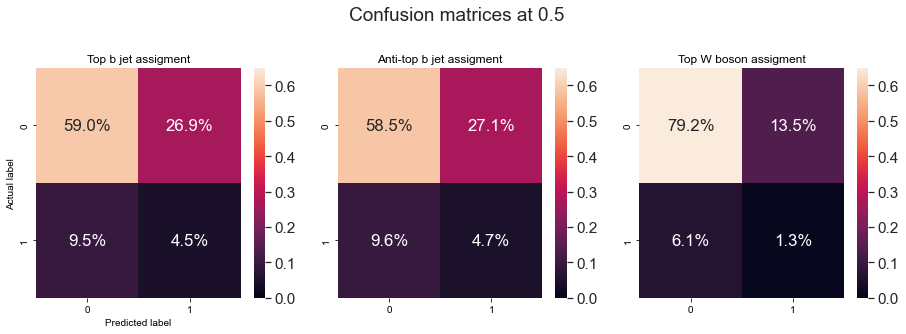

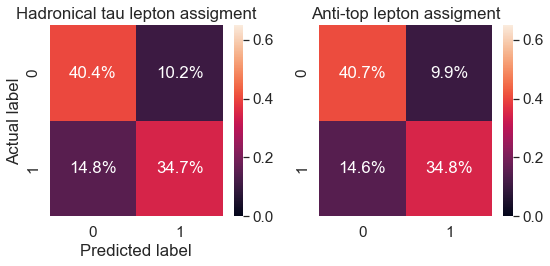

In [15]:
""" Confusion matrices. """
# inspired by source: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

model = keras.models.load_model("models/particle_assignment_model_real", custom_objects={ 'weighted_binary_crossentropy':create_weighted_binary_crossentropy, 'custom_f1':custom_f1, 'matthews_correlation':matthews_correlation})

from sklearn.metrics import confusion_matrix

test_predictions_baseline = model.predict(testing_generator)

n_batches = len(testing_generator)
y_test = np.concatenate([testing_generator[i][1] for i in range(n_batches)])


fig,axs = plt.subplots(1, 3, figsize=(13,4.8))

cm = confusion_matrix(y_test[:,0], test_predictions_baseline[:,0] > 0.5, normalize = 'all')
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt = '.1%', ax=axs[0], vmin = 0, vmax = 0.65)
plt.suptitle("Confusion matrices at 0.5", fontsize=19)
plt.rcParams.update({'axes.titlesize': 'large'})
plt.rcParams.update({'axes.labelsize': 'large'})
axs[0].title.set_text('{} assigment'.format("Top b jet"))
axs[0].set_ylabel('Actual label')
axs[0].set_xlabel('Predicted label')

cm = confusion_matrix(y_test[:,1], test_predictions_baseline[:,1] > 0.5, normalize = 'all')
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt = '.1%', ax=axs[1], vmin = 0, vmax = 0.65)

axs[1].title.set_text('{} assigment'.format("Anti-top b jet"))


cm = confusion_matrix(y_test[:,2], test_predictions_baseline[:,2] > 0.5, normalize = 'all')
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt = '.1%', ax=axs[2], vmin = 0, vmax = 0.65)

axs[2].title.set_text('{} assigment'.format("Top W boson"))

plt.tight_layout()
plt.savefig("figures/jest_assignment_real.pdf")
plt.show()


fig,axs = plt.subplots(1, 2, figsize=(8,4))

cm = confusion_matrix(y_test[:,3], test_predictions_baseline[:,3] > 0.5, normalize = 'all')
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt = '.1%', ax=axs[0], vmin = 0, vmax = 0.65)
axs[0].title.set_text('{} assigment'.format("Hadronical tau lepton"))
axs[0].set_ylabel('Actual label')
axs[0].set_xlabel('Predicted label')

cm = confusion_matrix(y_test[:,4], test_predictions_baseline[:,4] > 0.5, normalize = 'all')
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt = '.1%', ax=axs[1], vmin = 0, vmax = 0.65)
axs[1].title.set_text('{} assigment'.format("Anti-top lepton"))

plt.tight_layout()
plt.savefig("figures/leps_assignment_real.pdf")
plt.show()


In [17]:
for i in range(5):
    print(matthews_correlation(y_test[:,i].astype('float32'),test_predictions_baseline[:,i].astype('float32')))

tf.Tensor(0.007165408, shape=(), dtype=float32)
tf.Tensor(0.009416637, shape=(), dtype=float32)
tf.Tensor(0.018936204, shape=(), dtype=float32)
tf.Tensor(0.50186074, shape=(), dtype=float32)
tf.Tensor(0.5115832, shape=(), dtype=float32)
